In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d

sys.path.insert(0, "../")

import warnings
warnings.filterwarnings('ignore')

from michael import janet

2022-10-09 17:36:08.119110: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Hi there. Welcome to the good place.


In [2]:
uni = pd.read_csv("/Users/oliver hall/Research/unicorn/data/unicorn.csv", index_col=0)

In [15]:
index = 1

In [16]:
j = janet.boot(uni, index=index, use_prior=False)
j.prepare_data()

Already have data downloaded for Gaia ID 2174289161681454720.
If you want to check for new data, run `janet.update()`.
Removing 186 bad data points (out of 1121) using the TESS provided QUALITY array
Summing over 2 x 2 pixel lightcurves. Weighting=median
Removing 4 bad data points (out of 1130) using the TESS provided QUALITY array
Summing over 2 x 2 pixel lightcurves. Weighting=median


Running pixels in aperture: 100%|████████████| 300/300 [00:00<00:00, 314.73it/s]


In [17]:
j.get_rotation(period_range=(1, 10))

### Running Simple Astropy Lomb-Scargle on Sector 16-17 on star 2174289161681454720 ###
### Completed Simple Astropy Lomb-Scargle for Sector 16-17 on star 2174289161681454720 ###
### Running Wavelet Estimation for Sector 16-17 on star 2174289161681454720 ###


100%|█████████████████████████████████████████| 152/152 [00:02<00:00, 68.64it/s]


### Completed Wavelet Estimation for Sector 16-17 on star 2174289161681454720 ###
### Running Composite ACF estimation for Sector 16-17 on star 2174289161681454720 ###
### Completed Composite ACF estimation for Sector 16-17 on star 2174289161681454720 ###
### Running ACF Estimation on star 2174289161681454720 ###
### Completed ACF Estimation for Sector 16-17 on star 2174289161681454720 ###


IndexError: index 99 is out of bounds for axis 0 with size 99

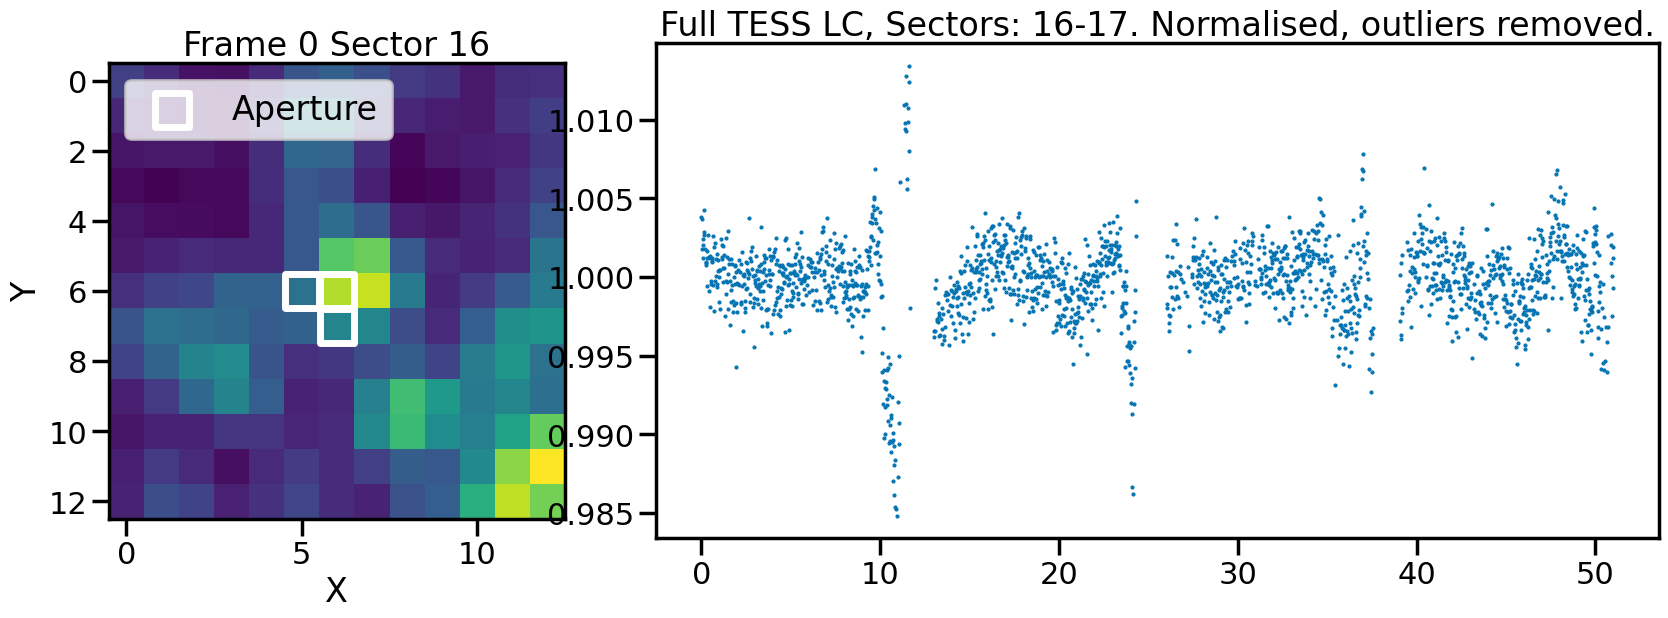

In [18]:
j.validate_rotation()
j.view()

IndexError: index 99 is out of bounds for axis 0 with size 99

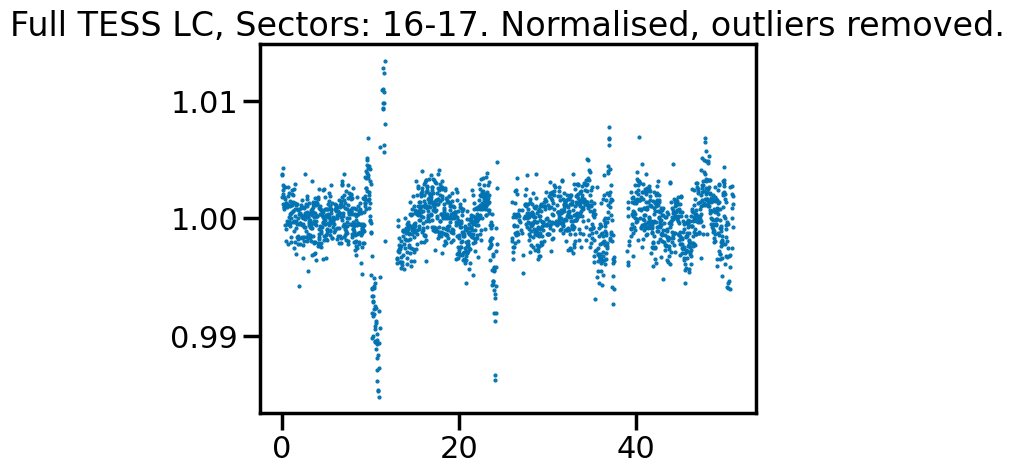

In [21]:
import lightkurve as lk
binfactor = 20

fig, ax = plt.subplots()
text = ''
if len(j.sectors) > 1:
    for s in j.sectors[:-1]:
        text += f'{s}, '
    text = text[:-2]
    text += f' & {j.sectors[-1]}'
else:
    text = j.sectors[0]
ax.set_title(f'Full TESS LC, Sectors: {text}. Normalised, outliers removed.')

xstep = 0
xlabels = []
xlocs = []
for s in j.sectors:
    lc = j.void[f'clc_{s}']
    xvals = lc.time.value - lc.time.value.min() + xstep
    ax.scatter(xvals, lc.flux, label=f'Sector(s) {s}', s=1)
    xstep = xvals.max()
    if s != j.sectors[-1]:
        ax.axvline(xstep, c='k', ls='-', lw=3, zorder=200)
    xlabels.append(np.nanpercentile(lc.time.value, [25, 50, 75]))
    xlocs.append(np.round(np.nanpercentile(xvals, [15, 50, 85]),2))

    binned = lk.LightCurve(time=xvals, flux=lc.flux).bin(bins = int(len(lc)/binfactor))
    if s == j.sectors[-1]:
        label = 'Binned LC'
    else:
        label = None
    binned.plot(ax=ax, zorder=104, lw=5, c=cmap[4], label=label)
    binned.plot(ax=ax, zorder=103, lw=10, c='w')

In [7]:
j.results

,SLS,e_SLS,h_SLS,f_SLS,SW,e_SW,h_SW,CACF,e_CACF,h_CACF,...,p2p_CACF,f_p2p_CACF,p2p_ACF,f_p2p_ACF,s_SLS,s_SW,s_CACF,overall,e_overall,f_overall
16-17,3.280436,0.072752,0.004540,0.0,3.497005,0.796231,0.9000,7.230148,0.396634,0.048669,...,0.028717,0.0,0.041647,0.0,NaN,NaN,NaN,NaN,NaN,NaN
24,2.781192,0.402667,0.000197,0.0,8.944097,1.907415,0.9753,8.770366,0.211507,0.076420,...,0.018623,0.0,0.006461,0.0,NaN,NaN,NaN,NaN,NaN,NaN
best,3.280436,0.072752,0.004540,0.0,3.497005,0.796231,0.9000,7.230148,0.396634,0.048669,...,NaN,NaN,NaN,NaN,16-17,16-17,16-17,3.280436,0.072752,641.0


Plot lightcurves

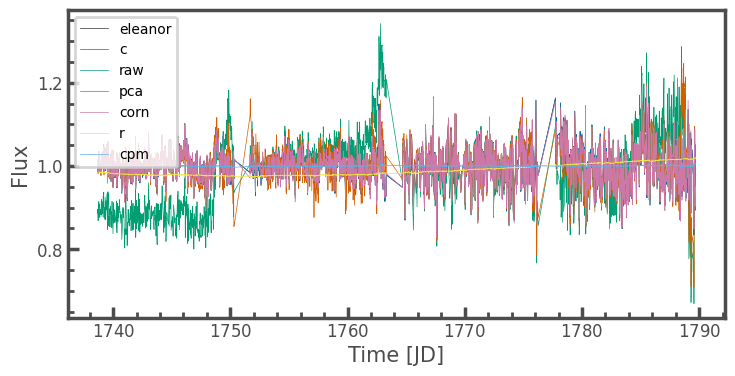

In [13]:
ax = j.void['clc_16-17'].plot(label='eleanor')

pls = ['c','raw','pca','corn','r', 'cpm']
for pl in pls:
    j.void[f'{pl}lc_16-17'].plot(ax=ax, label=pl)
ax.legend(fontsize=10)

3.292683409423734 d
27.0 d
3.292683409423734 d
3.292683409423734 d
27.0 d
24.41491599730582 d


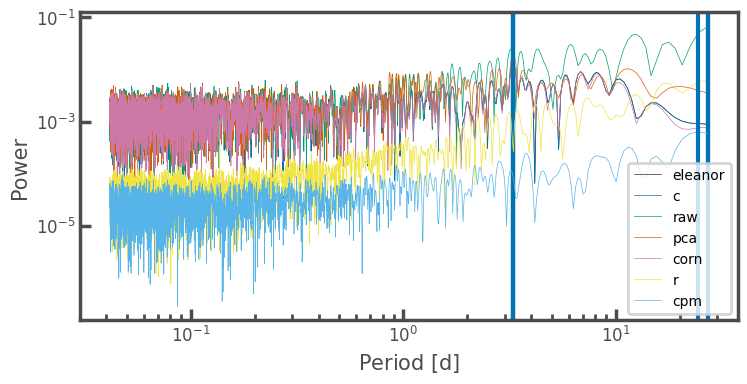

In [14]:
ax = j.void['clc_16-17'].to_periodogram(maximum_period=27).plot(label='eleanor', view='period')

pls = ['c','raw','pca','corn','r', 'cpm']
for pl in pls:
    j.void[f'{pl}lc_16-17'].to_periodogram(maximum_period=27).plot(ax=ax, label=pl,view='period', scale='log')
    ax.axvline(j.void[f'{pl}lc_16-17'].to_periodogram(maximum_period=27).period_at_max_power.value)
    print(j.void[f'{pl}lc_16-17'].to_periodogram(maximum_period=27).period_at_max_power)
ax.legend(fontsize=10)